<div style="text-align:right;">Use tensorboard to visualize NN</div>
<div style="text-align:right;">Brickea with material from mofan python</div>

# Tensorboard

In [10]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from matplotlib import pyplot as plt
%matplotlib

Using matplotlib backend: MacOSX


## Data

In [39]:
x_data = np.linspace(-1,1,300)[:,np.newaxis]
noise = np.random.normal(loc = 0,scale = 0.05,size = 300)[:,np.newaxis]
y_data = np.square(x_data) + noise + 3

(300, 1)


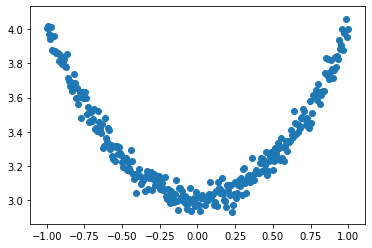

In [30]:
ax = plt.subplot(1,1,1)
ax.scatter(x_data,y_data)

## Layer

In [31]:
def add_layer(inputs,in_size,out_size,activation_function = None):
    with tf.name_scope('layer'):
        
        with tf.name_scope('Weights'):
            Weight = tf.Variable(tf.random.normal([in_size,out_size]),name = 'W')
        
        with tf.name_scope('bias'):
            biases = tf.Variable(tf.zeros([1,out_size])+0.1,name = 'b')
        
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs,Weight),biases)
        outputs = Wx_plus_b
        if activation_function is not None:
            outputs = activation_function(outputs)
            
        return outputs

## Input

使用with tf.name_scope('inputs')可以将xs和ys包含进来，形成一个大的图层，图层的名字就是with tf.name_scope()方法里的参数。

In [32]:
with tf.name_scope('Data'):
    x_input = tf.placeholder(tf.float32,[None,1])
    y_output = tf.placeholder(tf.float32,[None,1])

## Build Layer

In [33]:
l1 = add_layer(x_input,1,10,activation_function=tf.nn.relu)
predictions = add_layer(l1,10,1,activation_function=tf.nn.relu)

## Loss

In [34]:
with tf.name_scope("Loss"):
    loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.square(y_output - predictions),reduction_indices=[1]))

## Train Model

In [35]:
with tf.name_scope('Train'):
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [36]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(300):
        rs = sess.run(train_step,feed_dict = {x_input:x_data,y_output:y_data})
        if i % 50 ==0:
            
            predicts = sess.run(predictions,feed_dict={x_input:x_data,y_output:y_data})
            try:
                ax.lines.remove(lines[0])
            except Exception:
                pass
            lines = ax.plot(x_data,predicts,'r--',lw=5)
            plt.pause(1)
            print("loss %f" % sess.run(loss,feed_dict = {x_input:x_data,y_output:y_data}))

loss 4.776378
loss 0.004141
loss 0.003959
loss 0.003860
loss 0.003775
loss 0.003710


In [10]:
sess = tf.Session() # get session
# tf.train.SummaryWriter soon be deprecated, use following
writer = tf.summary.FileWriter("logs/", sess.graph)

终端中启用 ```tensorboard --logdir logs```

## More function

### Data 

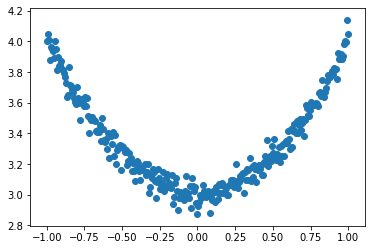

In [2]:
x_data = np.linspace(-1,1,300).astype(np.float32)[:,np.newaxis]
noise = np.random.normal(0,0.05,x_data.shape).astype(np.float32)
y_data = np.square(x_data) + 3 + noise
ax = plt.subplot(1,1,1)
ax.scatter(x_data,y_data)

### Weight and biases 变化表

接下来,我们层中的Weights设置变化图, tensorflow中提供了tf.histogram_summary()方法,用来绘制图片, 第一个参数是图表的名称, 第二个参数是图表要记录的变量

In [3]:
def add_layer_second(inputs,in_size,out_size,layer,activation_fucntion=None):
    layer_name = "layer%s"%layer
    with tf.name_scope(layer_name):
        
        with tf.name_scope('Weights'):
            Weights = tf.Variable(tf.random.normal([in_size,out_size]),name='W')
            tf.summary.histogram(layer_name + '/Weights',Weights)
        
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([1,out_size])+0.1,name='b')
            tf.summary.histogram(layer_name + '/biases',biases)
        
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs,Weights),biases,name='Wx_plus_b')
            
        outputs = Wx_plus_b
        if activation_fucntion is not None:
            outputs = activation_fucntion(Wx_plus_b)
                
        # 至于activation_function 可以不绘制. 我们对outputs 使用同样的方法:
        tf.summary.histogram(layer_name + '/outputs', outputs)
        
    return outputs
            
        

In [4]:
x_input = tf.placeholder(tf.float32,[None,1])
y_output = tf.placeholder(tf.float32,[None,1])

In [5]:
l1_second = add_layer_second(x_input,1,10,'layer_1',activation_fucntion=tf.nn.relu)
l2_second = add_layer_second(l1_second,10,1,'layer_output',activation_fucntion=None)

In [6]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.reduce_sum(tf.square(l2_second - y_output),reduction_indices=[1])
    )
    tf.summary.scalar('loss', loss) # tensorflow >= 0.12

In [7]:
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [8]:
init = tf.global_variables_initializer()

In [9]:
with tf.Session() as sess:
    merged = tf.summary.merge_all() # tensorflow >= 0.12
    writer = tf.summary.FileWriter("logs/", sess.graph)
    sess.run(init)
    for i in range(300):
        sess.run(train_step,feed_dict={x_input:x_data,y_output:y_data})
        if i % 50 ==0:
            rs = sess.run(merged,feed_dict={x_input:x_data,y_output:y_data})
            writer.add_summary(rs,i)
            print('loss %f'% sess.run(loss,feed_dict={x_input:x_data,y_output:y_data}))
            predicts = sess.run(l2_second,feed_dict={x_input:x_data,y_output:y_data})
            try:
                ax.lines.remove(lines[0])
            except Exception:
                pass
            lines = ax.plot(x_data,predicts,'r--',lw=5)
            plt.pause(1)
            

loss 0.344598
loss 0.006803
loss 0.005256
loss 0.004397
loss 0.003991
loss 0.003747
